In [1]:
import numpy as np
import cv2 as cv 
import matplotlib.pyplot as plt

# RANSAC : random sample consensus

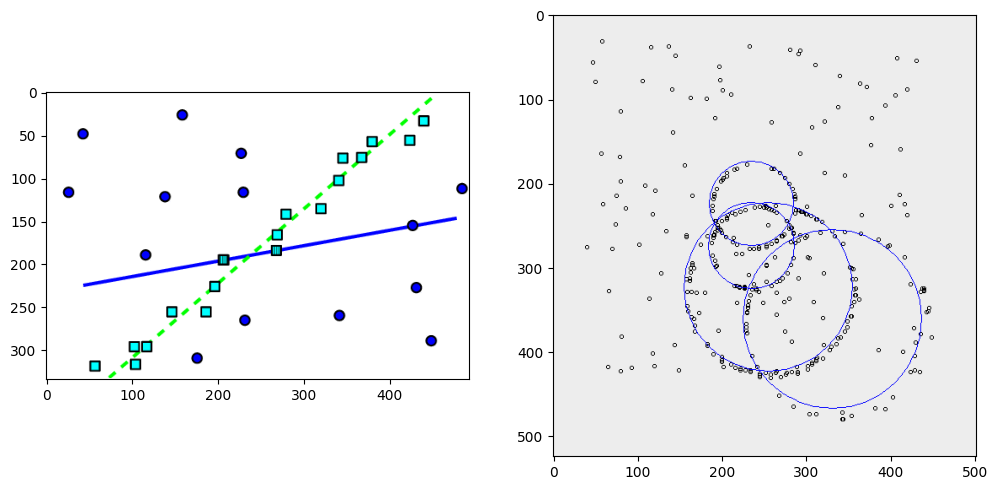

In [2]:
rasnac1 = cv.imread('rasnac1.png')
rasnac2 = cv.imread('rasnac2.png')
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(rasnac1)
plt.subplot(122)
plt.imshow(rasnac2)
plt.show()

## first step: choose random cordinate

In [3]:
def f_randomSample(row, col, n):
    # row: vertical cordinate
    # col: horizontal cordinate
    # n : number of sample 
    total_size = len(row)
    idx = np.random.permutation(np.arange(total_size))
    point = []
    for i in range(int(n)):
        position = idx[i]
        point.append([row[position], col[position]])
    
    return np.array(point)

# def randomSample_vectorize(row, col, n):
#     x = np.random.permutation(row)
#     y = np.random.permutation(col)
#     points = np.hstack((x[:n], y[:n]))

#     return points

In [4]:
r = np.arange(10)
c = r[::-1].copy()
point1, point2 = f_randomSample(r, c, 2)
point1, point2

(array([3, 6]), array([4, 5]))

## second step: find line between them

In [5]:
def find_line(point1, point2):
    # linear equation between 2 point: y = mx + h
    #                                  y2 = mx2 + h
    # solve use invers matrix: [[x1, 1], [x2, 1]]
    
#     s = f_randomSample(r, c, 2)
#     m = (point1[1] - point2[1]) / (point1[0] - point2[0])
#     h = point1[1] - m * point1[0]

    s = np.array([[point1[0], 1],
                 [point2[0], 1]])
    
    if (np.linalg.matrix_rank(s) == 2) and (np.linalg.det(s) != 0):
        m, h = np.dot(np.linalg.inv(s), [point1[1], point2[1]])
        return m, h
    else:
        return 0, 0

In [6]:
r = np.random.randint(0, 255, 500)
c = np.random.randint(0, 255, 500)
point1, point2 = f_randomSample(r, c, 2)
m, h = find_line(point1, point2)
m, h

(-0.9740259740259739, 211.064935064935)

### compute consistency
we should give a margin to the line to see is there any point in line neighbourhood.

check each point whether there is a point in its margin or not, we use RMS: (mx + h - y) ** 2

In [7]:
# r = np.arange(10)
# c = r[::-1].copy()
r = np.random.randint(-10, 10, 100)
c = np.random.randint(-10, 10, 100)
point1, point2 = f_randomSample(r, c, 2)
m, h = find_line(point1, point2)

def points_consistency(m, h, row, col, th):
    neighbour = 0
    for i in range(len(row)):
        distance = np.square(m * row[i] + h - (col[i]))
        if distance <= th:
            neighbour += 1
    
#     y = m * row + h
#     distance = np.square(y - col) < th
#     print(np.sum(distance.astype(np.int16)))
    return neighbour

def points_consistency_vectorize(m, h, row, col, th):
    
    y = m * row + h
    distance = np.square(y - col) < th
    neighbour = np.sum(distance.astype(np.int16))
    return neighbour

In [8]:
r = np.random.randint(0, 255, 500)
c = np.random.randint(0, 255, 500)
point1, point2 = f_randomSample(r, c, 2)
m, h = find_line(point1, point2)
points_consistency_vectorize(m, h, r, c, 2)

12

In [9]:
r = np.random.randint(0, 255, 500)
c = np.random.randint(0, 255, 500)
point1, point2 = f_randomSample(r, c, 2)
m, h = find_line(point1, point2)
points_consistency(m, h, r, c, 2)

7

In [10]:
def RANSACLine(EdgeImage, numIter=100, vectorize=True):
    EdgeImage = (EdgeImage > 0).astype(np.float64)
    idx = np.argwhere(EdgeImage)
    row, col = idx[:, 0], idx[:, 1]
    best_m, best_h = 0, 0
    max_score = -1
    for _ in range(numIter):
        p1, p2 = f_randomSample(row, col, 2)
        m, h = find_line(p1, p2)
        if vectorize:
            score = points_consistency_vectorize(m, h, row, col, 1)
        else:
            score = points_consistency(m, h, row, col, 2)
            
        if score > max_score:
            max_score = score
            best_m, best_h = m, h
        
    return best_m, best_h

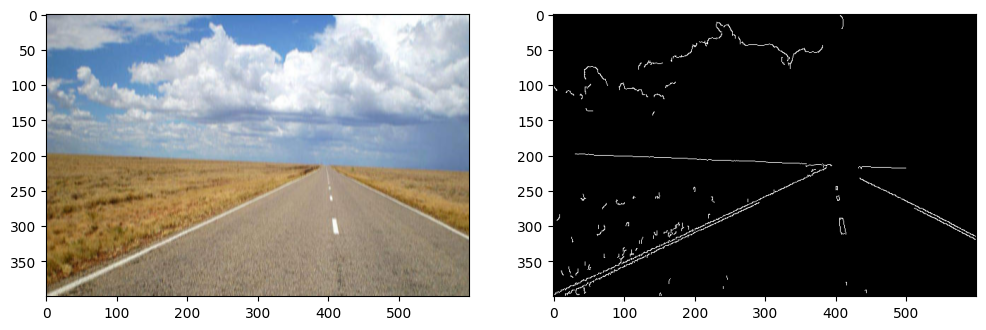

In [11]:
img = cv.imread('highway2.jpeg')
a = cv.getGaussianKernel(5, 2)
a2 = a @ a.T
img_s = cv.filter2D(img, -1, a)
edge_img = cv.Canny(img_s, 150, 250)
fig = plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_s[:, :, ::-1])
plt.subplot(122)
plt.imshow(edge_img, cmap='gray')
plt.show()

In [12]:
a, b = RANSACLine(edge_img)
a, b

(-2.153846153846154, 857.7692307692308)

In [13]:
# a1, b1 = RANSACLine(edge_img, vectorize=False)
# a1, b1

In [14]:
def f_getExtence(m, h, num_row, num_col):
    r1 = int(0)
    r2 = int(num_row - 1)
    c1 = int(m * r1 + h)
    c2 = int(m * r2 + h)
    
#     return (r1, c1), (r2, c2)
    return (c1, r1), (c2, r2) # in cv2 

In [15]:
s, e = f_getExtence(a, b, edge_img.shape[0], edge_img.shape[1])
s, e

((857, 0), (-1, 399))

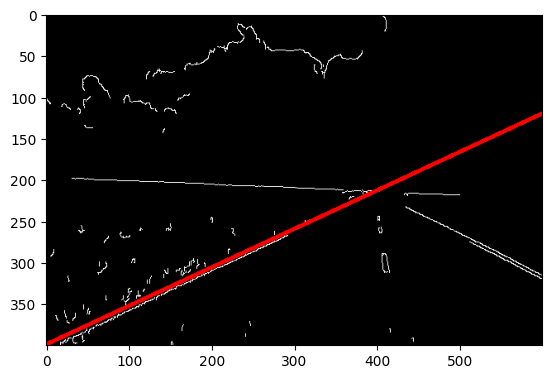

In [16]:
E2 = np.zeros((edge_img.shape[0], edge_img.shape[1], 3), dtype=np.uint8)
E3 = np.array(edge_img, dtype=np.uint8)
# E3[E3 == 0] = 255
E3[E3 > 0] = 255
E2[:, :, 0] = E3
E2[:, :, 1] = E3
E2[:, :, 2] = E3
I = cv.line(E2, s, e, (0, 0, 255), 3)
plt.imshow(I[:, :, ::-1])

In [17]:
def f_randomSample(row, col, n):
    total_size = len(row)
    idx = np.random.permutation(np.arange(total_size))
    point = []
    for i in range(int(n)):
        position = idx[i]
        point.append([row[position], col[position]])
    
    return np.array(point)

def find_line(point1, point2):
    s = np.array([[point1[0], 1],
                 [point2[0], 1]])   
    if (np.linalg.matrix_rank(s) == 2) and (np.linalg.det(s) != 0):
        m, h = np.dot(np.linalg.inv(s), [point1[1], point2[1]])
        return m, h
    else:
        return 0, 0

def points_consistency_vectorize(m, h, row, col, th):  
    y = m * row + h
    distance = np.square(y - col) < th
    neighbour = np.sum(distance.astype(np.float64))
    return neighbour
    
def RANSACLine(EdgeImage, numIter = 100):
    EdgeImage = (EdgeImage > 0).astype(np.float64)
    idx = np.argwhere(EdgeImage)
    row, col = idx[:, 0], idx[:, 1]
    best_m, best_h = 0, 0
    max_score = -1
    for _ in range(numIter):
        p1, p2 = f_randomSample(row, col, 2)
        m, h = find_line(p1, p2)
        score = points_consistency_vectorize(m, h, row, col, 1)            
        if score > max_score:
            max_score = score
            best_m, best_h = m, h
        
    r1 = int(0)
    r2 = int(EdgeImage.shape[0] - 1)
    c1 = int(best_m * r1 + best_h)
    c2 = int(best_m * r2 + best_h)
    point1 , point2 = (c1, r1), (c2, r2)
    
    E = np.zeros((EdgeImage.shape[0], EdgeImage.shape[1], 3), dtype=np.uint8)
    EdgeImage = EdgeImage.astype(np.uint8) * 255
#     EdgeImage[EdgeImage > 0] = 255
    E[:, :, 0] = E[:, :, 1] = E[:, :, 2] = EdgeImage
    
    return cv.line(E, point1 , point2, (0, 0, 255), 3)

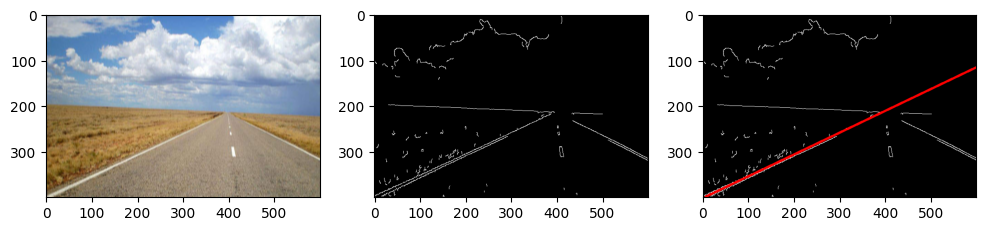

In [18]:
img = cv.imread('highway2.jpeg')
a = cv.getGaussianKernel(5, 2)
a2 = a @ a.T
img_s = cv.filter2D(img, -1, a)
edge_img = cv.Canny(img_s, 150, 250)
shape_img = RANSACLine(edge_img, 100)

fig = plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(img_s[:, :, ::-1])
plt.subplot(132)
plt.imshow(edge_img, cmap='gray')
plt.subplot(133)
plt.imshow(shape_img[:, :, ::-1])
plt.show()

# Circle
we need 3 point that they are not on one line

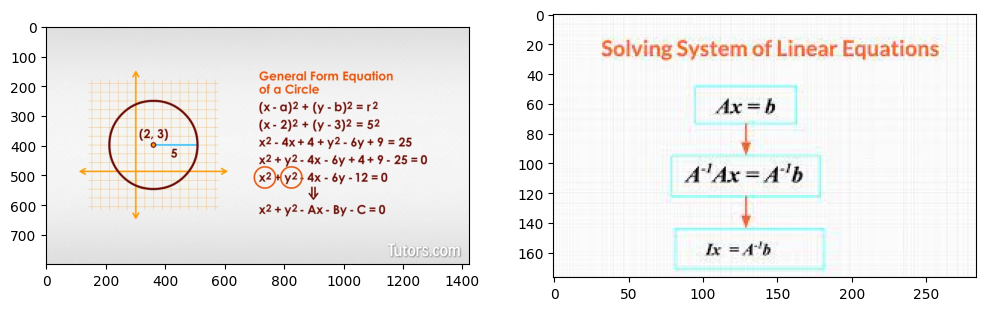

In [19]:
img = cv.imread('circleEquition.jpeg')
img2 = cv.imread('3equation3Unknown.jpeg')
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img[:, :, ::-1])
plt.subplot(122)
plt.imshow(img2[:, :, ::-1])
plt.show()

In [11]:
def f_randomSample(row, col, n):
    total_size = len(row)
    idx = np.random.permutation(np.arange(total_size))
    point = []
    for i in range(int(n)):
        position = idx[i]
        point.append([row[position], col[position]])
    
    return np.array(point)

def find_circle(point1, point2, point3):
    data = np.array([point1, point2, point3])
    answer = -np.sum(np.square(data), axis=1).reshape(3, 1)
    unknown = np.hstack((data, np.ones((3,1))))
    x_center, y_center, radius = 0, 0, 0
    if (np.linalg.matrix_rank(unknown) == 3) and (np.linalg.det(unknown) != 0):
        a, b, c = np.linalg.inv(unknown).dot(answer)
        x_center, y_center = -(a / 2), -(b / 2)
        if (a ** 2 + b ** 2) > (4 * c):
            radius = np.sqrt(a ** 2 + b ** 2 - 4 * c) / 2
        else:
            radius = 0

    return x_center, y_center, radius

def points_consistency_vectorize_circle(x_center, y_center, radius, row, col, th):  
    distance = np.square(row - x_center) + np.square(col - y_center)
    error = np.square(distance - np.square(radius)) < th
    score = np.sum(error.astype(np.float64))
    return score
    
def RANSAC_Circle(EdgeImage, threshold=3, numIter=1000):
    EdgeImage = (EdgeImage > 0).astype(np.float64)
    idx = np.argwhere(EdgeImage)
    row, col = idx[:, 0], idx[:, 1]
    best_x, best_y, best_radius = 0, 0, 0
    max_score = -1
    for _ in range(numIter):
        p1, p2, p3 = f_randomSample(row, col, 3)
        x, y, rad = find_circle(p1, p2, p3)
        score = points_consistency_vectorize_circle(x, y, rad, row, col, threshold)            
        if score > max_score:
            max_score = score
            best_x, best_y , best_radius = int(x), int(y), int(rad)
        
    
    E = np.zeros((EdgeImage.shape[0], EdgeImage.shape[1], 3), dtype=np.uint8)
    EdgeImage = EdgeImage.astype(np.uint8) * 255
#     EdgeImage[EdgeImage > 0] = 255
    E[:, :, 0] = E[:, :, 1] = E[:, :, 2] = EdgeImage
    
    return cv.circle(E, (best_y, best_x), best_radius, (0, 0, 255), 2)

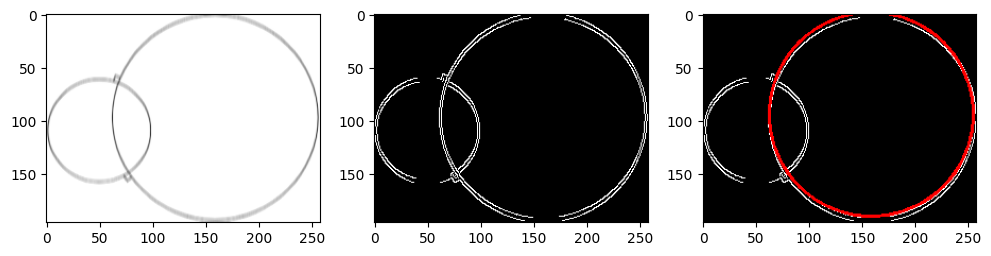

In [42]:
img = cv.imread('circle2.png')
a = cv.getGaussianKernel(5, 2)
a2 = a @ a.T
img_s = cv.filter2D(img, -1, a)
edge_img = cv.Canny(img_s, 170, 250)
shape_img = RANSAC_Circle(edge_img, 2, 2000)
# shape_img = cv.circle(img_s, (x, y), rad, (0, 0, 255), 3)
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(img_s[:, :, ::-1])
plt.subplot(132)
plt.imshow(edge_img, cmap='gray')
plt.subplot(133)
plt.imshow(shape_img[:, : , ::-1])
plt.show()